<a href="https://colab.research.google.com/github/jialun1221/scRNA-seq/blob/main/Preprocessing2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing and clustering PD astrocytes
### Part 2. Filtering, Normalization, Principle Component Analysis

In this notebook, we will apply ***normalization, scaling, and PCA***. 

In [ ]:
!pip install scanpy
!pip install matplotlib==3.1.3
import numpy as np
import pandas as pd
import scanpy as sc

In [ ]:
!mkdir data
!mkdir write

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.12.2 python-igraph==0.9.11 pynndescent==0.5.7


In [ ]:
# Create a file to store the processed data, without PCA
no_pca = 'write/no_pca.h5ad'

In [ ]:
# Create a file to store the processed data. This script will run PCA on adata.X, and store the result in adata.obsm.
pca_in_obsm = 'write/pca_in_obsm.h5ad'

In [ ]:
# Create a file to store the processed data. This script will run PCA on adata.X, and store the result in adata.obsm.
pca_in_obsm_2500 = 'write/pca_in_obsm_2500.h5ad'

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object.

In [ ]:
!pip install --quiet scvi-tools[tutorials]
import scvi

INFO:pytorch_lightning.utilities.seed:Global seed set to 0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Read in the new anndata (no LBD samples). It should have a size of n_obs × n_vars = 26535 × 41625.
adata = scvi.data.read_h5ad("drive/MyDrive/new_anndata.h5ad")

Makes the index unique by appending a number string to each duplicate index element: ‘1’, ‘2’, etc. [link text](https://anndata.readthedocs.io/en/latest/generated/anndata.AnnData.var_names_make_unique.html)

In [ ]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [ ]:
adata.var_names #this gives gene names!

Index(['RP11-34P13.3', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'RP11-34P13.14', 'RP11-34P13.9', 'FO538757.3', 'FO538757.2',
       'AP006222.2',
       ...
       'RNU2-71P', 'RNA5SP252', 'AC116533.2', 'AC114494.1', 'RN7SL424P',
       'RN7SL739P', 'MIR4502', 'RNU4-10P', 'RN7SL865P', 'RNU6-191P'],
      dtype='object', length=41625)

In [ ]:
adata.obs_names 
#these are number indices, not the lengthy barcode genes anymore. Maybe I dropped it?*Mark*

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '33496', '33497', '33498', '33499', '33500', '33501', '33502', '33503',
       '33504', '33505'],
      dtype='object', length=26535)

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

In [ ]:
from numpy import inf

In [ ]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


Show those genes that yield the highest fraction of counts in each single cell, across all cells. Can change the parameter `n_top` to any number of genes you want. 

normalizing counts per cell
    finished (0:00:03)


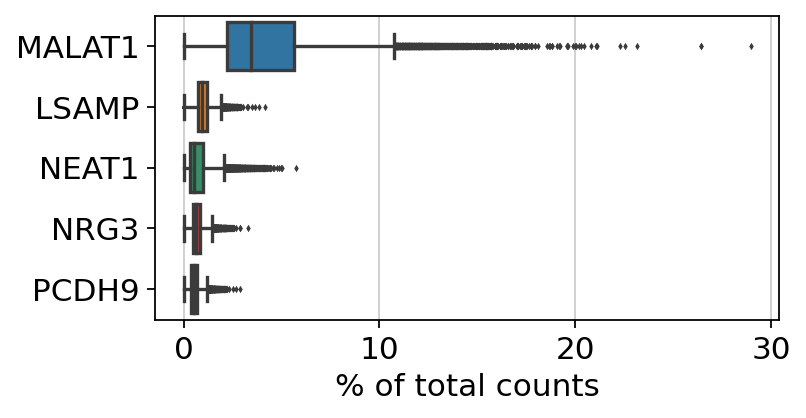

In [ ]:
#plot the highly expressed genes. 
sc.pl.highest_expr_genes(adata, n_top=5, )

**Basic filtering:**

In [ ]:
sc.pp.filter_cells(adata, min_genes=200) #Minimum number of genes expressed required for a cell to pass filtering.
sc.pp.filter_genes(adata, min_cells=3) #Minimum number of cells expressed required for a gene to pass filtering.

filtered out 10886 genes that are detected in less than 3 cells


Let's assemble some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
#Dimension check. It has fewer features now (n_obs × n_vars = 26535 × 30739) 
adata

AnnData object with n_obs × n_vars = 26535 × 30739
    obs: 'index', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cell_Subtype', 'Cell_Type', 'disease__ontology_label', 'organ__ontology_label', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Generated some qc metrics plot.

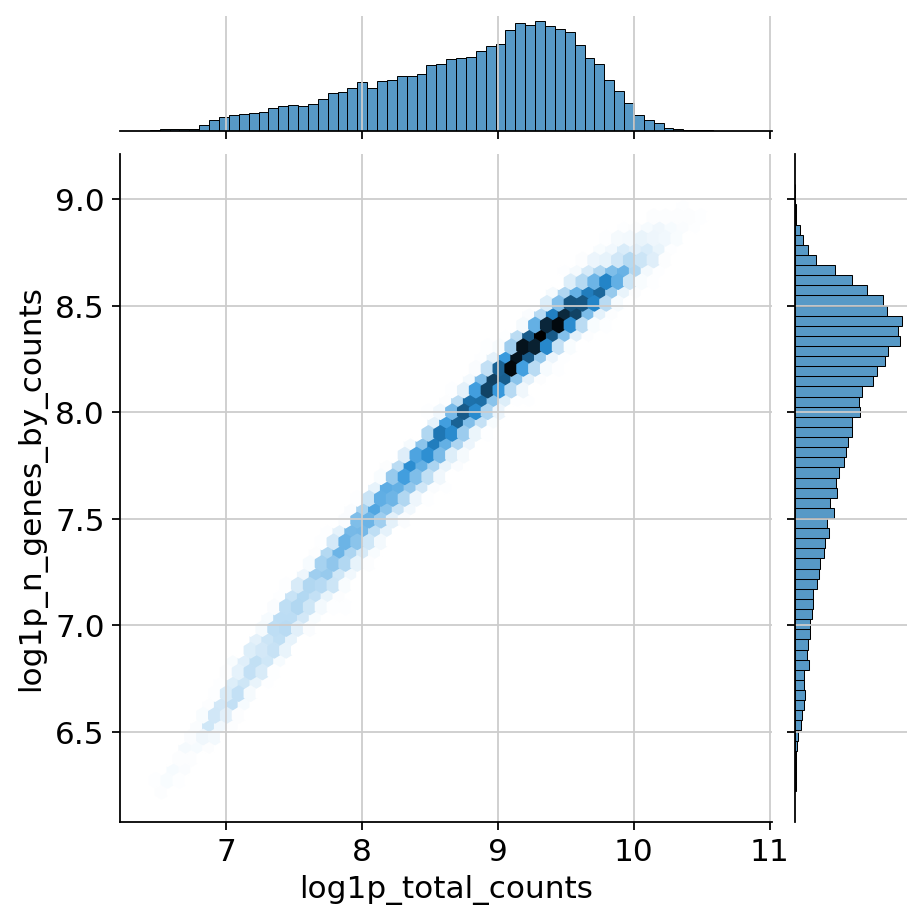

In [ ]:
import scanpy as sc
import seaborn as sns

adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)
sns.jointplot(
    data=adata.obs,
    x="log1p_total_counts",
    y="log1p_n_genes_by_counts",
    kind="hex",
)

<AxesSubplot:xlabel='pct_counts_mito', ylabel='Count'>

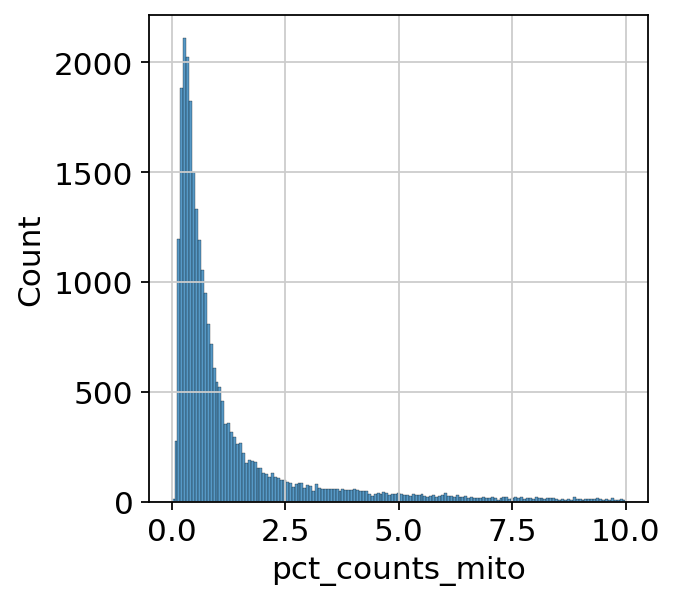

In [ ]:
sns.histplot(adata.obs["pct_counts_mito"])

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

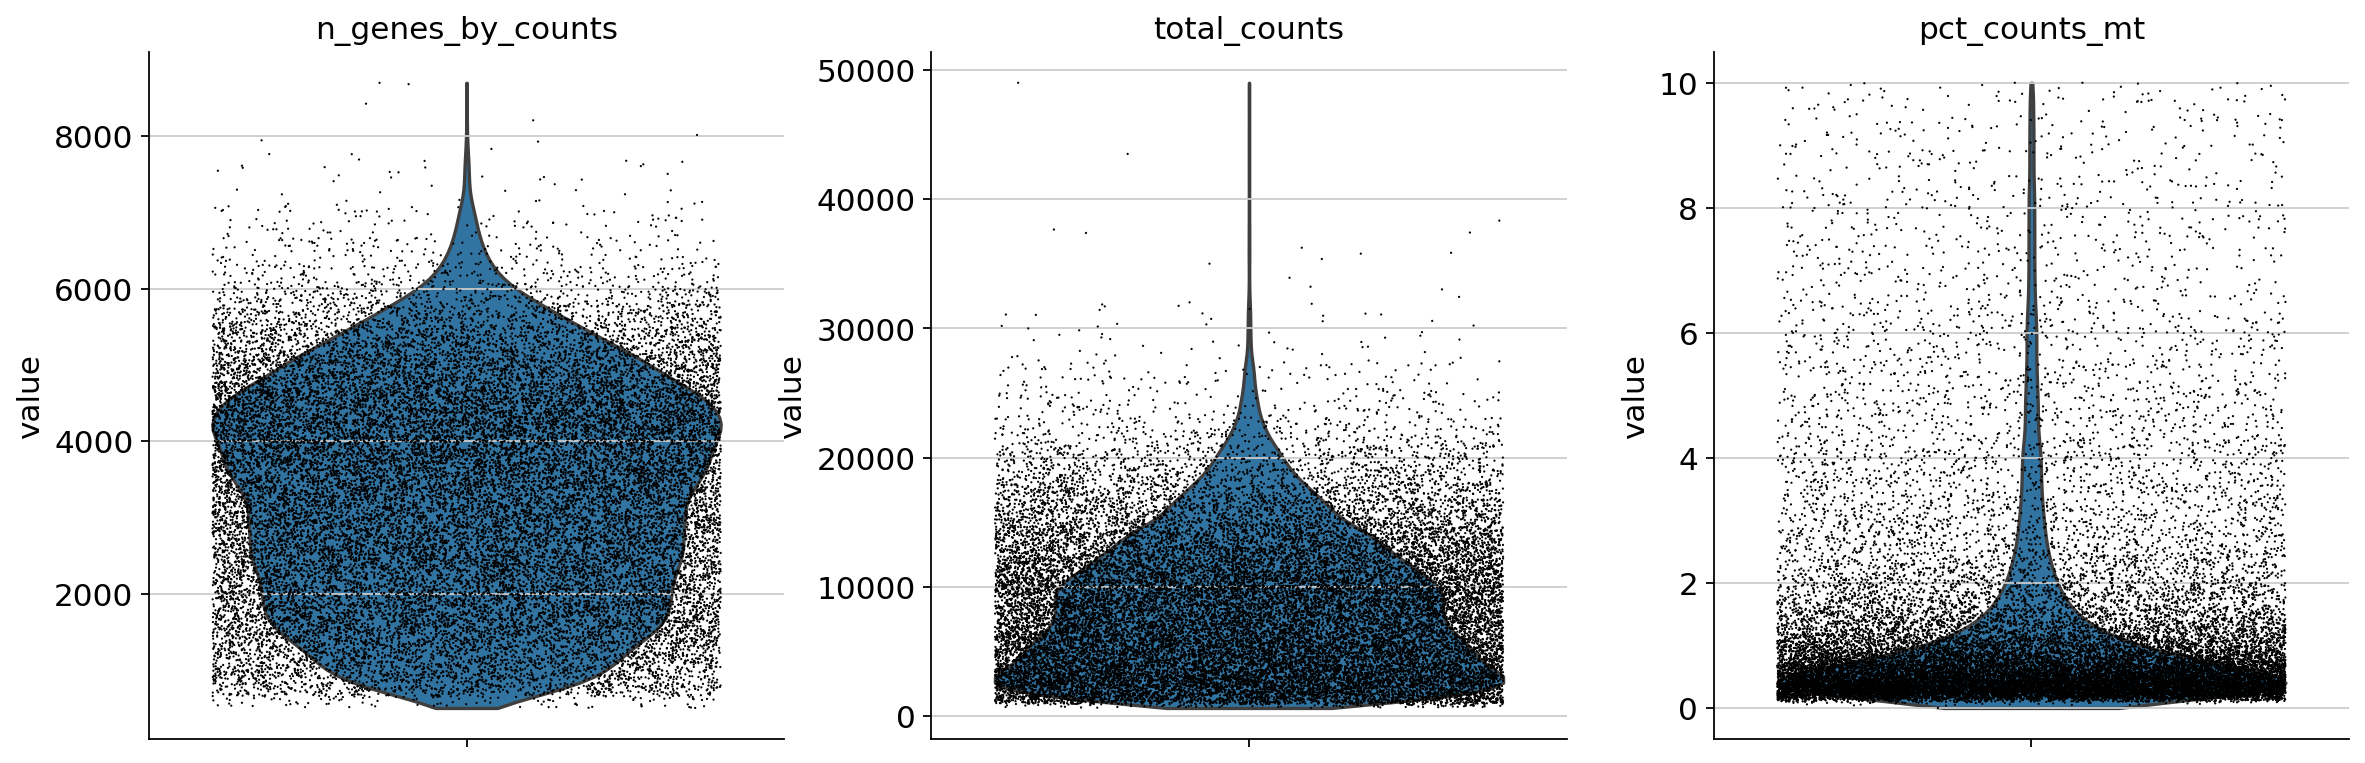

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
#Dimension check. (length: 26535 for both)
print(adata.obs.n_genes_by_counts)
print(adata.obs.total_counts)

0        7830
1        7290
2        7010
3        6905
4        6975
         ... 
33501    2974
33502    2719
33503    1381
33504     992
33505     909
Name: n_genes_by_counts, Length: 26535, dtype: int64
0        29989.0
1        28670.0
2        26473.0
3        22932.0
4        22217.0
          ...   
33501     6054.0
33502     6898.0
33503     2766.0
33504     1798.0
33505     1482.0
Name: total_counts, Length: 26535, dtype: float32


Remove cells that have too many ***mitochondrial genes*** expressed or too many ***total counts***:

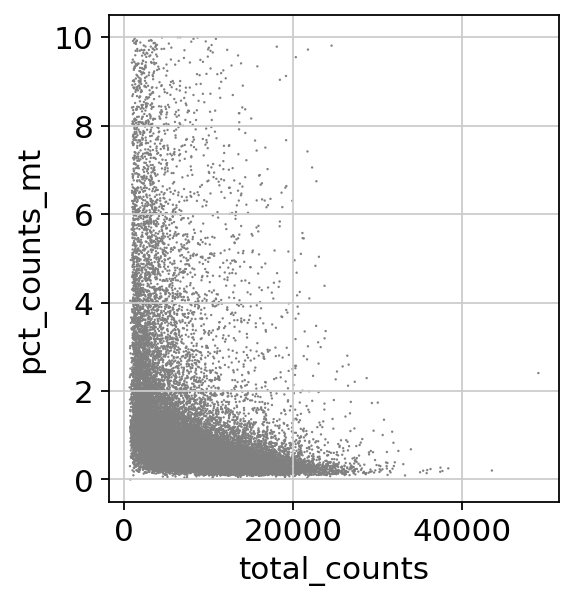

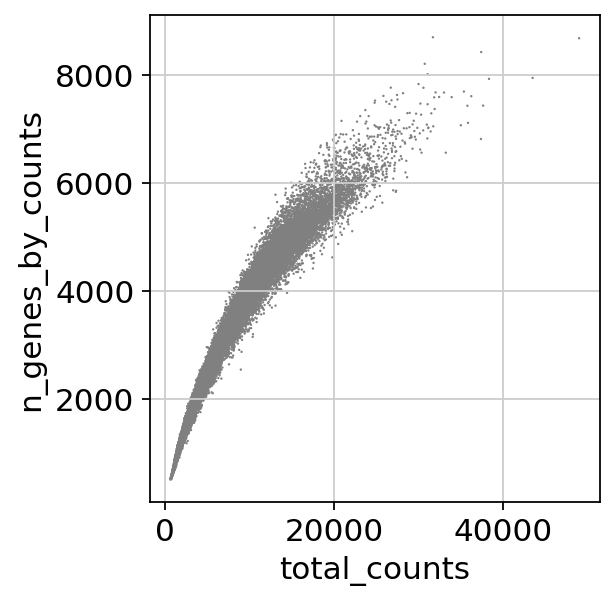

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Actually do the filtering by slicing the `AnnData` object.

In [ ]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :] #wants all the rows with number of counts <2500
adata = adata[adata.obs.pct_counts_mt < 5, :] #also has to have mt<5

In [ ]:
#Dimension check. It has even fewer features (n_obs × n_vars = 7491 × 30739). 
adata

View of AnnData object with n_obs × n_vars = 7491 × 30739
    obs: 'index', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cell_Subtype', 'Cell_Type', 'disease__ontology_label', 'organ__ontology_label', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mito', 'log1p_mean_counts', 'log1p_total_counts'

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [ ]:
sc.pp.log1p(adata)

Identify highly-variable genes.

**Note** <div>
Select one to run: <div>
Option A: no n_top_genes assigned ` ->` use the 3799 highly variable genes for PCA. File stored as `pca_in_obsm` <div>
Option B: Cutoff at n_top_genes = 2500 ` ->` use the top 2500 highly variable genes for PCA. File stored as `pca_in_obsm_2500` 


In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #A

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [ ]:
#TODO: turn top genes into list

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2500, min_mean=0.0125, max_mean=3, min_disp=0.5) #B

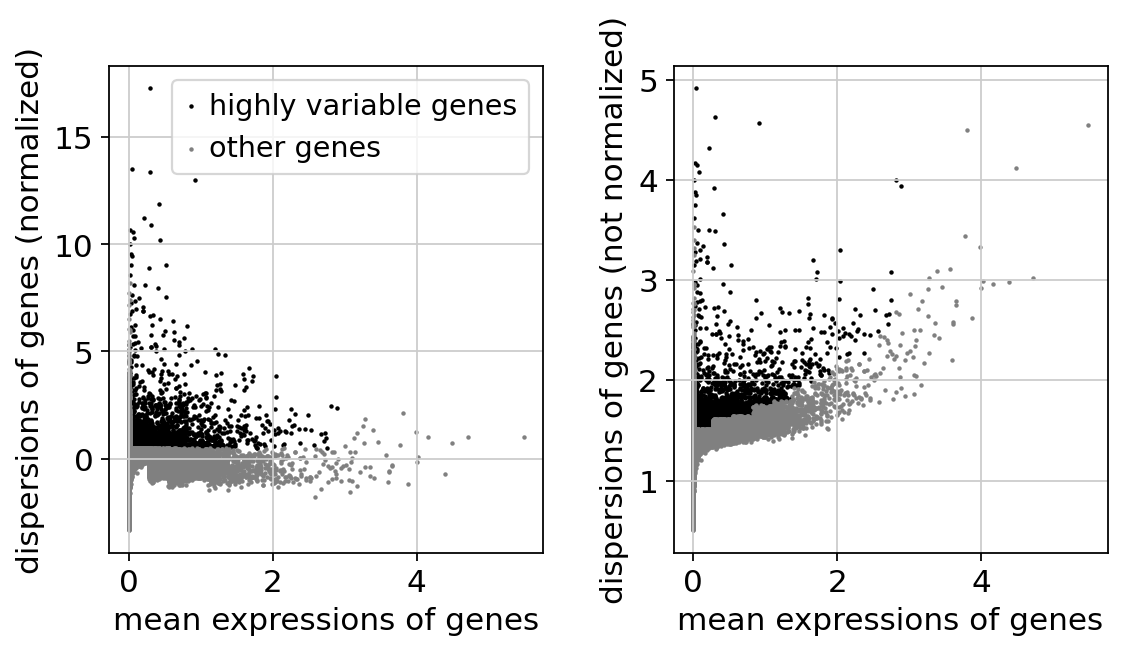

In [ ]:
sc.pl.highly_variable_genes(adata)

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

<div class="alert alert-info">

**Note**

You can get back an `AnnData` of the object in `.raw` by calling `.raw.to_adata()`.

</div>    

In [ ]:
adata.raw = adata

In [ ]:
adata.raw

<div class="alert alert-info">

**Note**
    
If you don't proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the previous highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.

</div>

Actually do the filtering

In [ ]:
adata = adata[:, adata.var.highly_variable] #2500 highly variable genes

In [ ]:
#Dimension check. (A: n_obs × n_vars = 7491 × 3849) (B: n_obs × n_vars = 7491 × 2500)
adata

View of AnnData object with n_obs × n_vars = 7491 × 3849
    obs: 'index', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cell_Subtype', 'Cell_Type', 'disease__ontology_label', 'organ__ontology_label', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mito', 'log1p_mean_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [ ]:
adata.X.shape

(7491, 3849)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:34)


In [ ]:
adata.obs.total_counts #check that the total counts are normalized & regressed

131      4398.0
132      4271.0
133      4122.0
134      3867.0
135      3735.0
          ...  
33474    5421.0
33476    3656.0
33487    4340.0
33504    1798.0
33505    1482.0
Name: total_counts, Length: 7491, dtype: float32

Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [ ]:
sc.pp.scale(adata, max_value=10)

In [ ]:
adata.X #check the X matrix to see if they have unit variance

array([[-0.18266311, -0.05484359, -0.144076  , ..., -0.11133515,
         1.0449122 , -0.09041635],
       [ 4.115225  , -0.04989586, -0.12478303, ..., -0.0860416 ,
         2.7124393 , -0.08605345],
       [-0.19330862, -0.05320782, -0.13162231, ..., -0.0926204 ,
         1.9033748 , -0.08900838],
       ...,
       [-0.17993364, -0.05572981, -0.1454354 , ..., -0.11229346,
         1.0585836 , -0.0912097 ],
       [-0.1451652 , -0.07355566, -0.13707277, ..., -0.07072501,
        -0.4549116 , -0.10737005],
       [-0.11688065, -0.08170589, -0.1552186 , ..., -0.08915591,
        -0.47298154, -0.11463422]], dtype=float32)

**Note** <div>
Stop here if you do not want to proceed to PCA. <div>
*since PCA will not give you direct features*

In [ ]:
adata.write(no_pca)

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the top 50 axes of variation and denoises the data. The results of will be saved in `adata.obs['X_pca']`

In [ ]:
sc.tl.pca(adata, n_comps = 50, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


In [ ]:
pca = pd.DataFrame(adata.obsm['X_pca'])

In [ ]:
pca

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-1.015640,4.039126,1.191854,-4.120292,10.407784,-0.348815,2.961909,1.254991,0.164291,-2.930142,...,-0.411252,0.097627,-0.251691,-0.743188,1.060174,-1.275088,-0.588340,0.006468,1.673970,0.181929
1,-3.654231,6.264527,-0.761382,-3.793192,9.756972,1.227088,4.190582,2.742381,0.296457,-1.613727,...,2.255469,-1.798632,-0.668016,-1.169563,-0.896920,-0.459990,-0.411980,-0.773220,1.575789,-1.503810
2,-2.937518,-2.054462,-0.862368,-3.290774,4.984015,0.147768,2.660787,3.344463,-0.184999,-2.912734,...,0.282237,-0.016558,-0.128153,1.380354,-0.826199,0.128411,-0.021535,0.595615,-1.043013,-1.301590
3,-2.048455,4.576511,-2.942744,-5.139398,10.296395,1.011355,4.154052,1.150494,0.305842,-1.952411,...,-0.592746,0.494264,-1.873753,1.929923,-1.017484,-1.910856,1.294145,2.428777,0.213066,1.509772
4,-2.797016,0.125942,0.248552,-5.896288,5.851717,-1.637999,4.048223,4.482919,3.542795,-0.634453,...,-0.997095,-1.057629,-2.773441,-1.856276,-0.229511,2.793479,-0.269947,-3.785958,1.953820,0.705039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7486,-2.003563,-2.516598,1.023085,7.532270,-0.100851,1.255790,0.570146,2.506476,-0.491732,-0.610752,...,0.092323,-0.002583,-1.108034,0.554084,-0.487010,-0.235247,-1.350021,-1.932956,0.044420,1.109460
7487,-1.977191,-5.173186,-1.677626,3.996444,-1.176907,0.408821,0.487254,1.643061,-1.668060,-0.730423,...,-0.347795,0.546434,-0.977657,-0.905449,0.367170,1.275375,1.589180,0.827945,0.692276,1.392344
7488,3.132754,4.939884,3.391904,6.602614,0.827472,-4.146325,-1.167174,0.531964,-1.201550,1.269333,...,1.107979,0.726448,0.529723,1.187565,-1.891675,0.616914,1.060503,0.584097,-0.797407,-1.009675
7489,-2.514857,-3.960183,-2.957200,-0.615743,-1.796025,-0.104493,1.098988,1.912259,1.896687,-0.617143,...,-2.321156,1.250000,-2.054707,-0.317265,-0.258180,-2.184021,0.345067,-0.153075,1.800982,-1.124582


In [ ]:
o = adata.uns['pca']

In [ ]:
import sys

In [ ]:
print(sys.getsizeof(o))
print(len(o))
print(o)

248
3
{'params': {'zero_center': True, 'use_highly_variable': True}, 'variance': array([65.09687  , 22.884731 , 17.31853  , 10.900078 ,  9.061336 ,
        7.404236 ,  6.1812134,  5.855545 ,  5.221549 ,  4.7357554,
        4.3694096,  3.9287407,  3.7825775,  3.587159 ,  3.556154 ,
        3.4253752,  3.312382 ,  3.2116299,  3.0485785,  3.0187936,
        2.9237318,  2.9129467,  2.8720691,  2.8043113,  2.7515395,
        2.7263308,  2.7120242,  2.69346  ,  2.668282 ,  2.6611753,
        2.6396298,  2.6263487,  2.607141 ,  2.6031518,  2.5865054,
        2.58122  ,  2.5777075,  2.5726635,  2.5616808,  2.554527 ,
        2.5498066,  2.5469806,  2.542391 ,  2.5384164,  2.5312276,
        2.5262938,  2.522775 ,  2.5180452,  2.515233 ,  2.511672 ],
      dtype=float32), 'variance_ratio': array([0.01919089, 0.00674654, 0.00510559, 0.0032134 , 0.00267133,
       0.00218281, 0.00182225, 0.00172624, 0.00153934, 0.00139613,
       0.00128812, 0.00115821, 0.00111512, 0.00105751, 0.00104837,
       

In [ ]:
adata.varm['PCs'].shape

(2500, 50)

In [ ]:
adata.obsm['X_pca'].shape

(7491, 50)

In [ ]:
adata.var['features'].shape

(2500,)

In [ ]:
pcadata = sc.AnnData(pca)
print(pca)

In [ ]:
pcadata = sc.AnnData(pca)
print(pca)

In [ ]:
pcadata.write(pca_file) #writing the pcadata array into file

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

TypeError: ignored

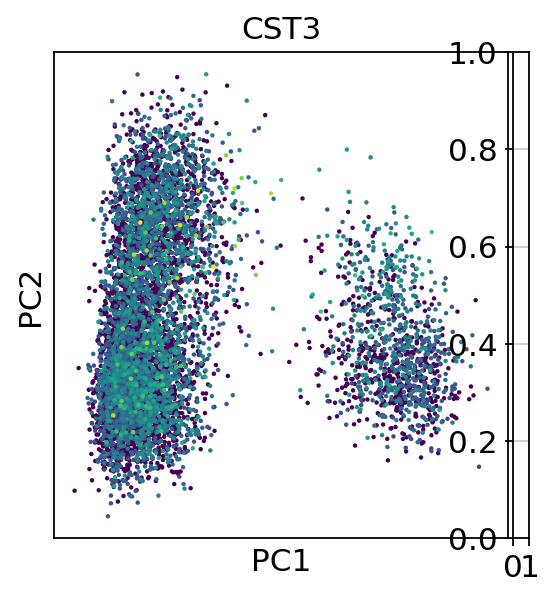

In [ ]:
sc.pl.pca(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often a rough estimate of the number of PCs does fine.

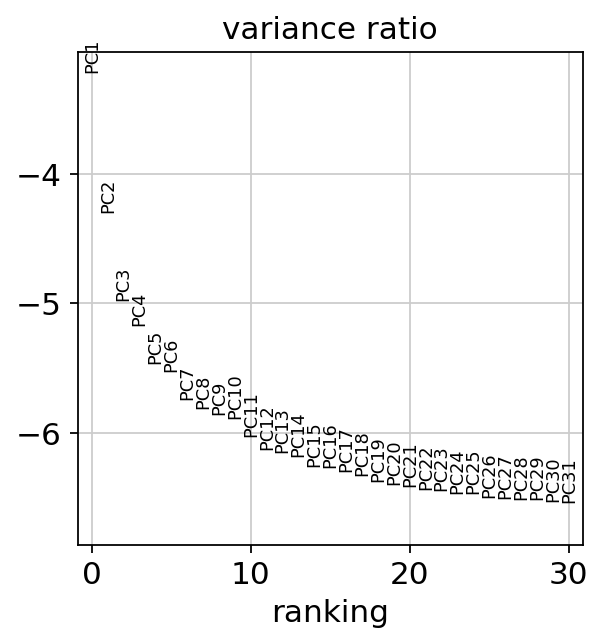

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [ ]:
adata.write(pca_in_obsm) #A

In [ ]:
adata.write(pca_in_obsm_2500) #B

In [ ]:
adata

AnnData object with n_obs × n_vars = 7491 × 2500
    obs: 'index', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cell_Subtype', 'Cell_Type', 'disease__ontology_label', 'organ__ontology_label', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'features', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mito', 'log1p_mean_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [ ]:
adata.varm['PCs'].shape

(2500, 50)